# Clustering Overlapping Half Disks

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.mixture
import scipy
import pandas as pd
from sklearn.preprocessing import KernelCenterer

#import code to generate data and do clustNP
from sample_distributions import sample_half_disks
from clustNP import clustNP, gauss_kernal_mat, gen_ZG, gen_C, clustNP_obj, proj_simplex

# Set Parameters

In [2]:
np.random.seed(0) #reproducibility

n = 600 # number of total paired samples
nhold = 120
ntest = 120
M = 3   # true number of mixture components for our KDE
d = 2   # ambient dimension 

# Generate Data

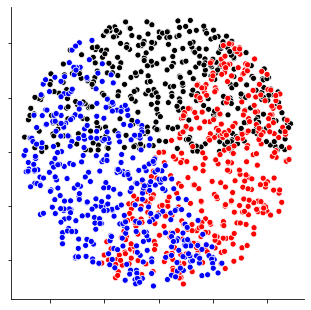

In [3]:
X, component_ids, pair_ids = sample_half_disks(n, rand_state=0)
Xh, cid_h, pid_h = sample_half_disks(nhold, rand_state=111)
Xte, cid_te, pid_te = sample_half_disks(ntest, rand_state=99)
#plot the data and look at moons

dftr = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": component_ids[:,], "true_class": component_ids[:,]})
dfh = pd.DataFrame({"x": Xh[:,0], "y": Xh[:,1], "decisions": cid_h[:,], "true_class": cid_h[:,]})

#tn, fp, fn, tp = confusion_matrix(decisions_train, component_ids).ravel()
#plot data and decisions
sns.relplot(x ="x", y="y", data=dftr, hue="decisions", palette=['k', 'r', 'b'], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
plt.savefig('true_half_disks.eps', format="eps")
plt.savefig('true_half_disks.png', dpi=300)

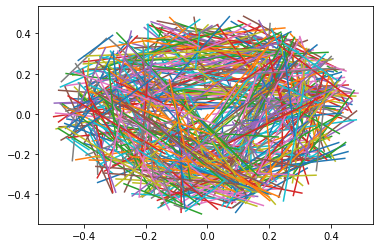

In [4]:
for i in range(n):
    pair = X[pair_ids==i]
    plt.plot(pair[:,0], pair[:,1])

# solve quartic problem

### Original Param Init

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set(style="darkgrid")

# do a line search on sigma to find the best eigenvector initialization
Rs = [10,20,30,40,50]
best_ISE = 1e10;

for R in Rs:
    d = X.shape[1]
    sd = np.min(np.std(X, axis=0))
    sigmas = [sd*(R)**(-1/(d+4))]
    Z, _ = gen_ZG(X, R, sigmas[0])
    for sigma in sigmas:
        _ , Gh = gen_ZG(Xh, R, sigma, Z=Z)
        Ch = gen_C(Xh, pid_h, Z, R, sigma)
        #Generate initialization for current sigma
        Z, G = gen_ZG(X, R, sigma, Z=Z)
        C = gen_C(X, pair_ids, Z, R, sigma)
        w, A  = scipy.sparse.linalg.eigs(G, k=M)
        w = np.real(w)
        A = np.real(A)
        for i in range(M):
                A[:,i] = proj_simplex(A[:,i])
        w = w/np.sum(w)
        A = A / np.sum(A,axis=0)
        
        f, _ = clustNP_obj(A, w, G, C, n, 0)
        print(sigma, R, f)
        if f < best_ISE:
            best_ISE = f
            best_sigma = sigma
            best_R = R
            best_w = w
            best_Z = Z
            best_C = C
            best_G = G
            best_A = A
print(best_sigma, best_R, best_ISE)       

0.16899426493904826 10 0.09064083826374066
0.150556774007267 20 0.08611195719311371
0.1407186815350198 30 0.03831034823820028
0.13413083697041892 40 0.04728077342975574
0.1292340532934933 50 0.04648449805309624
0.1407186815350198 30 0.03831034823820028


### Optimize

In [6]:
sigma = best_sigma
R = best_R
w0 = best_w
#w0 = np.array([0.5, 0.5])
Z = best_Z
C = best_C
G = best_G
A0 = best_A
#A0 = np.random.rand(R,M)
#A0 = A0 / np.sum(A0, axis=0)
ss=3

print(best_ISE)

# #solve
f_star, A_star, w_star, Z, n_iter = clustNP(X, pair_ids.astype("int"), A0, w0, Z, G, stepsize=ss, ss_decr=1, 
                                            epoch_decr = 1, method='psgd', max_iter=200, f_tol=1e-16, 
                                            grad_tol=1e-8, R=R, sigma=sigma, batch_size=64, backtrack=False,
                                            decay=0.001, momentum=0.2)

f_star

0.03831034823820028


0.008669712880282496


# Plot KDE

(-0.7, 0.7, -0.7, 0.7)

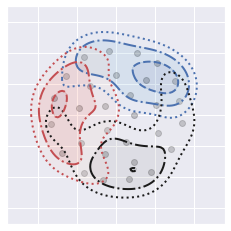

In [7]:
import sklearn.neighbors 

xmin, xmax = -0.7, 0.7
ymin, ymax = -0.7, 0.7
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
#construct kde based on discretization and learned weights
#evaluate on grid of points

#class 0
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[0]*A_star[:,0]).clip(1e-16))
f0 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 1
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[1]*A_star[:,1]).clip(1e-16))
f1 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 2
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[2]*A_star[:,2]).clip(1e-16))
f2 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))


#plot


# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# Contourf plot
plt.scatter(x=Z[:,0], y=Z[:,1], color="black", alpha = 0.2)

#plt.scatter(x=Z[Zlabels==1,0], y=Z[Zlabels==1,1], color='orange')
# cfset = ax.contourf(xx, yy, f0, cmap='Blues')
# cfset = ax.contourf(xx, yy, f1, cmap='Reds')

levels = [0.95, 1.3, 1.7, 2]
# levels = [1.2, 1.8, 2.2, 2.5]

CSr = plt.contourf(xx, yy, f0, levels, cmap="Blues", alpha=sigma)
CSr2 = plt.contour(xx, yy, f0, levels,
                  colors=('b',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower")
# CSr.cmap.set_under('k')
# plt.clabel(CSr2, fmt='%2.1f', colors='k', fontsize=12)
# plt.colorbar(CSr)
CSb = plt.contourf(xx, yy, f1, levels, cmap="Greys", alpha=sigma)
CSb2 = plt.contour(xx, yy, f1, levels,
                  colors=('k',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower")
# plt.clabel(CSb2, fmt='%2.1f', colors='k', fontsize=12)
#plt.colorbar(CSb)
CSk = plt.contourf(xx, yy, f2, levels, cmap="Reds", alpha=sigma)
CSk2 = plt.contour(xx, yy, f2, levels,
                  colors=('r',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower")
# plt.clabel(CSg2, fmt='%2.1f', colors='k', fontsize=12)
#plt.colorbar(CSg)

plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axis('square')

# lines = CSr2.collections[:-1]
# plt.legend(lines, levels[:-1])

# plt.savefig('halfdisks_kde_orig_init.eps', format="eps")
# plt.savefig('halfdisks_kde_orig_init.png', dpi=300)

# Predict

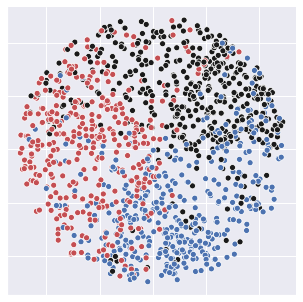

In [8]:
#make predictions
phats_train = np.zeros((X.shape[0], M))
phats_te = np.zeros((Xte.shape[0], M))
for i in range(X.shape[0]):
    kx = gauss_kernal_mat(X[i, np.newaxis], Z, sigma)
    phats_train[i, :] = kx@A_star
for i in range(Xh.shape[0]):
    kxte = gauss_kernal_mat(Xte[i,np.newaxis], Z, sigma)
    phats_te[i, :] = kxte@A_star
ltr = np.zeros((X.shape[0], M))
lte = np.zeros((Xte.shape[0], M))
for i in set(pair_ids):
    ltr[pair_ids==i, :] = np.tile(w_star.T*np.prod(phats_train[pair_ids==i,np.newaxis], axis=0), (2,1))
lte = w_star.T*phats_te
decisions_train = np.argmax(ltr, 1)
decisions_te = np.argmax(lte, 1)


dftr = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": decisions_train[:,], "true_class": component_ids[:,]},)
dfte = pd.DataFrame({"x": Xte[:,0], "y": Xte[:,1], "decisions": decisions_te[:,], "true_class": cid_te[:,]})

#tn, fp, fn, tp = confusion_matrix(decisions_train, component_ids).ravel()
#plot data and decisions
sns.relplot(x ="x", y="y", data=dftr, hue="decisions", palette=['k', 'b', 'r'], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
#plt.savefig('halfdisks_orig_init.png', dpi=300)
# df_nmf = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": nmf_labels, "true_class": component_ids})
# # #plot data and decisions
# sns.relplot(x ="x", y="y", data=df_nmf, hue="decisions")

In [9]:
#compute best accuracy of clustering
cm = sklearn.metrics.confusion_matrix(component_ids, decisions_train, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
acc

0.6799999999999999

In [10]:
sklearn.metrics.adjusted_rand_score(component_ids, decisions_train)

0.33462474937101866

# Spectral Clustering

In [11]:
import sklearn.cluster
spclust = sklearn.cluster.SpectralClustering(n_clusters=M)
spclust.fit(X)
#d = clust.get_params()

SpectralClustering(n_clusters=3)

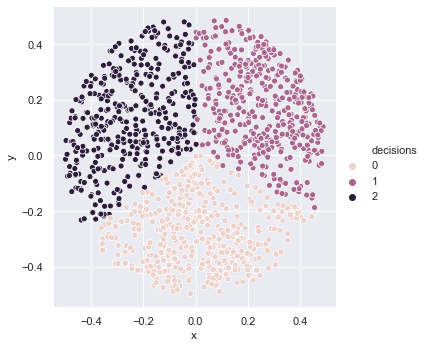

In [12]:
#np.sum(spclust.labels_)
#spclust.affinity_matrix_
dfh = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": spclust.labels_, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=dfh, hue="decisions")

# Constrained Spectral Clustering

In [13]:
from clustering_methods import constr_spec_clust


connectivity = np.zeros((2*n, 2*n))
for i in range(n):
    i, j = tuple(np.nonzero(pair_ids==i)[0])
    connectivity[i,j] = 1
    connectivity[j,i] = 1
Q = connectivity
A = spclust.affinity_matrix_
beta = 45
u_star, labels, _ = constr_spec_clust(A, Q, beta=beta, n_clust=M)

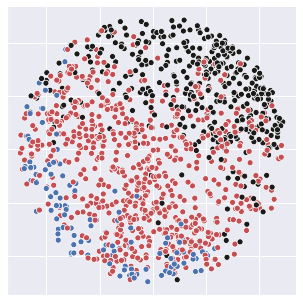

In [14]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": labels, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['b', 'k', 'r'], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
# plt.savefig('halfdisks_constr_spectral.eps', format="eps")
# plt.savefig('halfdisks_constr_spectral.png', dpi=300)

In [15]:
#compute best accuracy of clustering

cm = sklearn.metrics.confusion_matrix(component_ids, labels, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
acc

0.5425

In [16]:
sklearn.metrics.adjusted_rand_score(component_ids, labels)

0.1735629231255111

# PCK-means

In [17]:
from sklearn import datasets, metrics
from active_semi_clustering.semi_supervised.pairwise_constraints import PCKMeans
pck = PCKMeans(n_clusters=M)
# generate list of tuples for pairwise constraints
ml = [tuple(np.nonzero(pair_ids==i)[0]) for i in range(n)]
pck.fit(X, ml=ml)

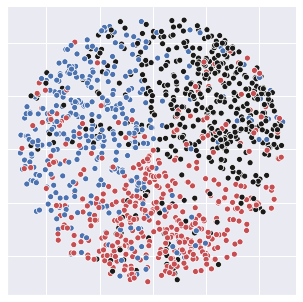

In [18]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": pck.labels_, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['r', 'k', 'b'], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
# plt.savefig('halfdisks_pckmeans.eps', format="eps")
# plt.savefig('halfdisks_pckmeans.png', dpi=300)

In [19]:
#compute best accuracy of clustering

cm = sklearn.metrics.confusion_matrix(component_ids, pck.labels_, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
acc

0.5533333333333333

In [20]:
sklearn.metrics.adjusted_rand_score(component_ids, pck.labels_)

0.26079089798252125

# NPMIX

In [21]:
from NPMIX import NPMIX
labels, ofit_gmm, gmm_assn = NPMIX(X, M=M, M_over=2*M)

0.5549999999999999 0.24844261854085375


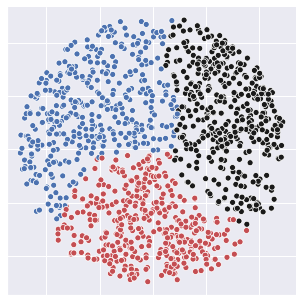

In [22]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": labels, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['b','r', 'k'], legend=False)
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
plt.savefig('halfdisks_npmix.eps', format="eps")
plt.savefig('halfdisks_npmix.png', dpi=300)


cm = sklearn.metrics.confusion_matrix(component_ids, labels, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
ARI = sklearn.metrics.adjusted_rand_score(component_ids, labels)        
print(acc, ARI)

# Constrained GMM for paired samples

In [23]:
from constr_gmm import constr_gmm
M=3
constr_gmm = constr_gmm(X,pair_ids,M,100,0)     
constr_gmm.run()
labels= np.argmax(constr_gmm.predict(X), axis=1)

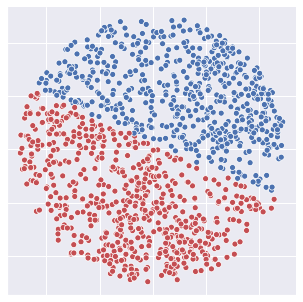

In [24]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": labels, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['b','r'], legend=False)
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal')
plt.savefig('halfdisks_constr_gmm.eps', format="eps")
plt.savefig('halfdisks_constr_gmm.png', dpi=300)

In [25]:
#compute best accuracy of clustering

cm = sklearn.metrics.confusion_matrix(component_ids, labels, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
acc

0.5716666666666667

In [26]:
sklearn.metrics.adjusted_rand_score(component_ids, labels)

0.227199212051508

# MV-LVM

In [27]:
X1, cid1, pid1 = sample_half_disks(n//3, rand_state=0)
X2, cid2, pid2 = sample_half_disks(n//3, rand_state=111)
X3, cid3, pid3 = sample_half_disks(n//3, rand_state=222)

In [28]:
from clustering_methods import MVLVM
sd = np.min(np.std(X, axis=0))
sigma = sd*(2*n)**(-1/(d+4))
A, w = MVLVM(X1,X2,X3,k=5,sigma=sigma, n_iter=200, reg=0.1*sigma)
Xa = np.vstack((X1,X2))

(-0.7, 0.7, -0.7, 0.7)

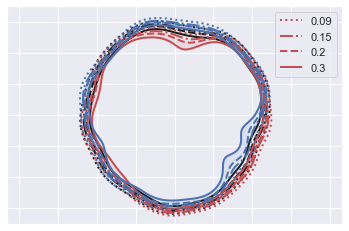

In [29]:
import sklearn.neighbors 

xmin, xmax = -0.7, 0.7
ymin, ymax = -0.7, 0.7
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
#construct kde based on discretization and learned weights
#evaluate on grid of points

#class 0
kde0 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde0.fit(Xa, y=None, sample_weight=(A[:,0]).clip(1e-16))
f0 = np.exp(np.reshape(kde0.score_samples(positions.T).T, xx.shape))

#class 1
kde1 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde1.fit(Xa, y=None, sample_weight=(A[:,1]).clip(1e-16))
f1 = np.exp(np.reshape(kde1.score_samples(positions.T).T, xx.shape))

#class 2
kde2 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde2.fit(Xa, y=None, sample_weight=(A[:,2]).clip(1e-16))
f2 = np.exp(np.reshape(kde2.score_samples(positions.T).T, xx.shape))



#plot

# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)
# Contourf plot
# plt.scatter(x=Z[:,0], y=Z[:,1], color="black", alpha = 0.2)
#plt.scatter(x=Z[Zlabels==1,0], y=Z[Zlabels==1,1], color='orange')
# cfset = ax.contourf(xx, yy, f0, cmap='Blues')
# cfset = ax.contourf(xx, yy, f1, cmap='Reds')

levels = [0.09, 0.15, 0.2, 0.3]


CSb = plt.contourf(xx, yy, f0, levels, cmap="bone", alpha=sigma)
CSb2 = plt.contour(xx, yy, f0, levels,
                  colors=('k',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSb.cmap.set_over('g')
# plt.clabel(CSb2, fmt='%2.1f', colors='g', fontsize=10)
#plt.colorbar(CSb)
CSg = plt.contourf(xx, yy, f1, levels, cmap="Reds", alpha=sigma)
CSg2 = plt.contour(xx, yy, f1, levels,
                  colors=('r',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSg.cmap.set_over('r')
#plt.clabel(CSg2, fmt='%2.2f', colors='k', fontsize=10)
#plt.colorbar(CSg)
CSk = plt.contourf(xx, yy, f2, levels, cmap="Blues", alpha=sigma)
CSk2 = plt.contour(xx, yy, f2, levels,
                  colors=('b',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSk.cmap.set_over('b')
#plt.clabel(CSk2, fmt='%2.1f', colors='b', fontsize=10)
#plt.colorbar(CSk)


lines = CSg2.collections
plt.legend(lines, levels)


plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axis('equal')
# plt.imshow(np.rot90(f0.clip(1e-1)), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# plt.imshow(np.rot90(f1.clip(1e-1)), cmap='Reds', extent=[xmin, xmax, ymin, ymax])
# plt.savefig('halfdisks_kde_mvlvm.eps', format="eps")
# plt.savefig('halfdisks_kde_mvlvm.png', dpi=300)

[]

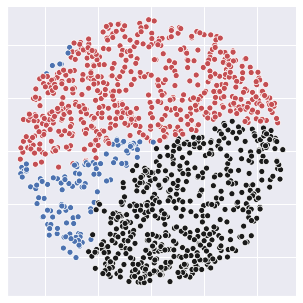

In [30]:
#make predictions
vals_tr = np.zeros((Xa.shape[0] + X3.shape[0],M))
vals_tr[:,0] = kde0.score_samples(np.vstack((Xa,X3)))
vals_tr[:,1] = kde1.score_samples(np.vstack((Xa,X3)))
vals_tr[:,2] = kde2.score_samples(np.vstack((Xa,X3)))
decisions_train = np.argmax(vals_tr, 1)
vals_te = np.zeros((Xte.shape[0],M))
# vals_te[:,0] = kde0.score_samples(Xte)
# vals_te[:,1] = kde1.score_samples(Xte)
# decisions_te = np.argmax(vals_te, 1)


dftr = pd.DataFrame({"x": np.hstack((Xa[:,0],X3[:,0])), "y": np.hstack((Xa[:,1],X3[:,1])), "decisions": decisions_train[:,], "true_class": np.hstack((cid1,cid2,cid3)).T},)
# dfte = pd.DataFrame({"x": Xte[:,0], "y": Xte[:,1], "decisions": decisions_te[:,], "true_class": cid_te[:,]})

#tn, fp, fn, tp = confusion_matrix(decisions_train, component_ids).ravel()
#plot data and decisions
sns.relplot(x ="x", y="y", data=dftr, hue="decisions", palette=['b', 'k', 'r'], legend=False)
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.set_aspect('equal')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# plt.savefig('halfdisks_mvlvm.png', dpi=300)

# GMM

In [31]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=M)
labels = gmm.fit_predict(X)

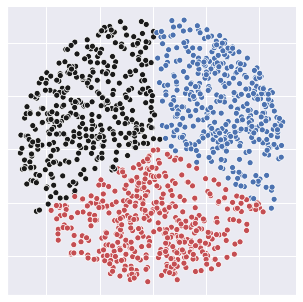

In [32]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": labels, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['b', 'k', 'r'], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')
plt.savefig('halfdisks_gmm.eps', format="eps")
plt.savefig('halfdisks_gmm.png', dpi=300)

In [33]:
#compute best accuracy of clustering

cm = sklearn.metrics.confusion_matrix(component_ids, labels, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
acc

0.5033333333333333

In [34]:
sklearn.metrics.adjusted_rand_score(component_ids, labels)

0.25023560410430323